- Họ tên: Võ Minh Tùng
- MSHV: 2370345

Kết nối Colab với Google Drive để lấy dữ liệu

Cài đặt thư viện Gensim cho việc train model Word2Vec

In [ ]:
!pip install gensim

Import các thư viện cần thiết

In [ ]:
import os
import re
import pandas as pd
import string
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Load tập dữ liệu từ thư mục trong Google Drive

#II. Load Reuters-21578 corpus and preprocess it
using Reuters-21578  corpus https://www.kaggle.com/datasets/nltkdata/reuters

In [ ]:
import pandas as pd
from tensorflow.keras.datasets import reuters
from tensorflow.keras.utils import to_categorical

# Tải dữ liệu từ reuters dataset
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# Tạo từ điển để chuyển đổi chỉ số thành từ
word_index = reuters.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

# Hàm để giải mã bài viết từ danh sách các chỉ số
def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review])

# Giải mã các bài viết trong tập huấn luyện
train_texts = [decode_review(article) for article in train_data]

# Chuyển nhãn thành một danh sách
train_labels_list = list(train_labels)

# Tạo DataFrame từ các bài viết và nhãn
df_train = pd.DataFrame({
    'text': train_texts,
    'label': train_labels_list
})

# Lấy 2000 dòng đầu tiên

df_train = df_train.iloc[:1000]
train_data = df_train['text'].to_list()


# Load data
def load_data(csv_file):
    return pd.read_csv(csv_file, encoding="latin")



stopwords_list=stopwords.words('english')

def clean_data(w):
    w = w.lower()
    w = re.sub(r"'s\b","", w)
    w = re.sub("[^a-zA-Z]", " ", w)
    words = w.split()
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words)


def get_inp(list_sent):
    sent=list(map(clean_data, list_sent))
    sent=list(map(lambda x: x.split(" "), sent))
    return sent

# print(train_data[:1000])
inp_data=get_inp(train_data)
print(inp_data[:5])

[['said', 'result', 'december', 'acquisition', 'space', 'expects', 'earnings', 'per', 'share', 'dlrs', 'per', 'share', 'cts', 'company', 'said', 'pretax', 'net', 'rise', 'nine', 'mln', 'dlrs', 'six', 'mln', 'dlrs', 'rental', 'operation', 'revenues', 'mln', 'dlrs', 'mln', 'dlrs', 'said', 'cash', 'flow', 'per', 'share', 'year', 'three', 'dlrs', 'reuter'], ['generale', 'banque', 'heller', 'overseas', 'corp', 'chicago', 'taken', 'pct', 'stakes', 'company', 'factors', 'generale', 'banque', 'said', 'statement', 'gave', 'financial', 'details', 'transaction', 'turnover', 'billion', 'belgian', 'francs', 'reuter'], ['shr', 'dlrs', 'cts', 'shr', 'diluted', 'dlrs', 'cts', 'net', 'mln', 'avg', 'shrs', 'mln', 'mln', 'year', 'shr', 'dlrs', 'dlrs', 'shr', 'diluted', 'dlrs', 'dlrs', 'net', 'mln', 'mln', 'avg', 'shrs', 'mln', 'mln', 'note', 'earnings', 'per', 'share', 'reflect', 'two', 'one', 'split', 'effective', 'january', 'per', 'share', 'amounts', 'calculated', 'preferred', 'stock', 'dividends', 'lo

Train model Word2Vec. Trong quá trình train, có bạn có thể chỉnh sử dụng GPU của Colab để đẩy nhanh tiến độ bằng cách vào Rumtime => Change Runtime Type và chọn GPU

In [ ]:
# Skipgram model
model = Word2Vec(inp_data, min_count = 1, vector_size  = 256, window = 5, sg = 1)
model.build_vocab(inp_data, update=True)

model.train(inp_data, total_examples=model.corpus_count, epochs=50)
model.wv.save('word2vec_skipgram.bin')


# CBOW model
model = Word2Vec(inp_data, min_count = 1, vector_size = 256, window = 5, sg = 0)
model.build_vocab(inp_data, update=True)

model.train(inp_data, total_examples=model.corpus_count, epochs=50)
model.wv.save('word2vec_CBOW.bin')


Sau khi có model. Ta tiến hành load mô hình

In [ ]:
import gensim
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from scipy.spatial import distance
path = 'word2vec_CBOW.bin'
model = gensim.models.KeyedVectors.load(path)

In [ ]:
with open("vocab.txt", "w", encoding="utf-8") as f:
    for x in model.key_to_index:
        f.write(x + "\n")

Test kết quả

In [ ]:
model.most_similar(positive=['space'], topn=10)

[('defence', 0.8406894207000732),
 ('voluntary', 0.758317232131958),
 ('dominican', 0.7490900158882141),
 ('talk', 0.7442892789840698),
 ('premier', 0.7439020276069641),
 ('arsenide', 0.7415757179260254),
 ('gallium', 0.7413410544395447),
 ('records', 0.7410016059875488),
 ('acting', 0.7383056879043579),
 ('mainframe', 0.7280860543251038)]

In [ ]:
word_0 = "company"
word_1 = "management"
word_2 = "stock"

word_0_eb = model[word_0]
word_1_eb = model[word_1]
word_2_eb = model[word_2]

dst_0_1 = distance.euclidean(word_0_eb, word_1_eb)
dst_1_2 = distance.euclidean(word_1_eb, word_2_eb)
dst_2_0 = distance.euclidean(word_2_eb, word_0_eb)

print("OUTPUT DISTANCE")
print("0 vs 1: ", dst_0_1)
print("1 vs 2: ", dst_1_2)
print("2 vs 0: ", dst_2_0)

OUTPUT DISTANCE
0 vs 1:  13.214262962341309
1 vs 2:  17.174386978149414
2 vs 0:  19.46879768371582


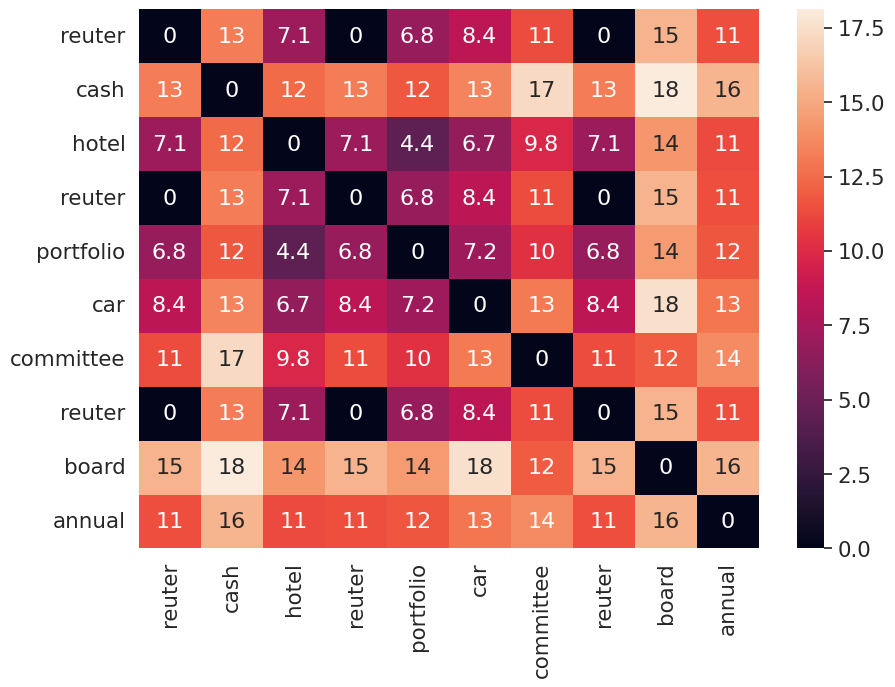

In [ ]:
from scipy.spatial import distance_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

list_words = ["reuter", "cash", "hotel", "reuter", "portfolio", "car", "committee", "reuter", "board", "annual"]
list_word_embs = list(map(lambda x: model[x], list_words))

dm = distance_matrix(list_word_embs, list_word_embs, p=2)

df_dm = pd.DataFrame(dm, list_words, list_words)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_dm, annot=True, annot_kws={"size": 16}) # font size

plt.show()
